### **Assignment 2 - Kaggle Competition**

### **Abstract**

In this competition, Home Depot is looking to improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to incease the number of iterations their team can perform the current search algorithms.

### **Data**

This dataset contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the combinations of search terms and product pairs. 

The relevance number is a number between 1 (not relevant) to 3 (highly relevant). 

The task is to predict the relevance for each pair listed in the test set. The test set contains both seen and unseen search terms.

Kaggle Competition and Dataset link - https://www.kaggle.com/c/home-depot-product-search-relevance/overview

In [210]:
#Importing Libraries and Models
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import rcParams
from sklearn import metrics
from google.colab import files


#Importing Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline
stemmer = SnowballStemmer('english')

In [ ]:
"%pwd

'/content'

### **Reading The Data**

There are 4 Files that need to be read in.

1. train.csv is the Training Set data
2. test.csv is the Test Dataset
3. Product_desc.csv contains the product ID and the Product Descriptions
4. Attr.csv contains the Product attributes

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('drive/My Drive/Colab Notebooks/train.csv', encoding='latin-1')
df_test = pd.read_csv('drive/My Drive/Colab Notebooks/test.csv', encoding='latin-1')
df_product_desc = pd.read_csv('drive/My Drive/Colab Notebooks/product_descriptions.csv')
df_attr = pd.read_csv('drive/My Drive/Colab Notebooks/attributes.csv')

In [ ]:
print(df_train.shape, df_test.shape, df_product_desc.shape, df_attr.shape)

(74067, 5) (166693, 4) (124428, 2) (2044803, 3)


In [ ]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [ ]:
df_product_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [ ]:
df_attr.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [ ]:
num_train = df_train.shape[0]

In [ ]:
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [ ]:
def str_common_word(str1, str2):
  return sum(int(str2.find(word)>=0) for word in str1.split())


**Merging all the Data files into one Training Set for Pre Processing**

In [ ]:
df = pd.concat((df_train, df_test), axis = 0, ignore_index=True)

In [ ]:
df = pd.merge(df, df_product_desc, how="left", on='product_uid')

In [ ]:
df.shape

(240760, 6)

In [ ]:

df.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


**Stemming with NLTK and converting Text into Numerical Values**





In [ ]:
df['search_term'] = df['search_term'].map(lambda x:str_stemmer(x))
df['product_title'] = df['product_title'].map(lambda x:str_stemmer(x))
df['product_description'] = df['product_description'].map(lambda x:str_stemmer(x))

In [ ]:
df.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.00,"not onli do angl make joint stronger, they als..."
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.50,"not onli do angl make joint stronger, they als..."
2,9,100002,behr premium textur deckov 1-gal. #sc-141 tugb...,deck over,3.00,behr premium textur deckov is an innov solid c...
3,16,100005,delta vero 1-handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom with the delta vero single...
4,17,100005,delta vero 1-handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom with the delta vero single...


In [ ]:
df['len_of_query'] = df['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df['product_info'] = df['search_term']+"\t"+df['product_title']+"\t"+df['product_description']

df['word_in_title'] = df['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df['word_in_description'] = df['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))


In [174]:
df.head()

,id,product_uid,relevance,len_of_query,word_in_title,word_in_description
0,2,100001,3.00,2,1,1
1,3,100001,2.50,2,1,1
2,9,100002,3.00,2,1,1
3,16,100005,2.33,3,1,1
4,17,100005,2.67,3,3,2


In [ ]:
df = df.drop(['search_term','product_title','product_description','product_info'],axis=1)

In [ ]:
df.head(20)

,id,product_uid,relevance,len_of_query,word_in_title,word_in_description
0,2,100001,3.00,2,1,1
1,3,100001,2.50,2,1,1
2,9,100002,3.00,2,1,1
3,16,100005,2.33,3,1,1
4,17,100005,2.67,3,3,2
5,18,100006,3.00,2,1,2
6,20,100006,2.67,3,2,2
7,21,100006,3.00,1,1,1
8,23,100007,2.67,2,2,2
9,27,100009,3.00,2,2,2


 **Determining Correlation Coefficient in the Features**

In [163]:
df.corr(method='pearson')

,id,product_uid,relevance,len_of_query,word_in_title,word_in_description
id,1.000000,0.984194,-0.116426,0.096151,0.146612,0.043556
product_uid,0.984194,1.000000,-0.130656,0.086953,0.136357,0.036414
relevance,-0.116426,-0.130656,1.000000,-0.072279,0.210162,0.157640
len_of_query,0.096151,0.086953,-0.072279,1.000000,0.662104,0.670285
word_in_title,0.146612,0.136357,0.210162,0.662104,1.000000,0.727751
word_in_description,0.043556,0.036414,0.157640,0.670285,0.727751,1.000000


**MultiColinearity exists between many independent variables as observed on the correlation heatmap and the table**

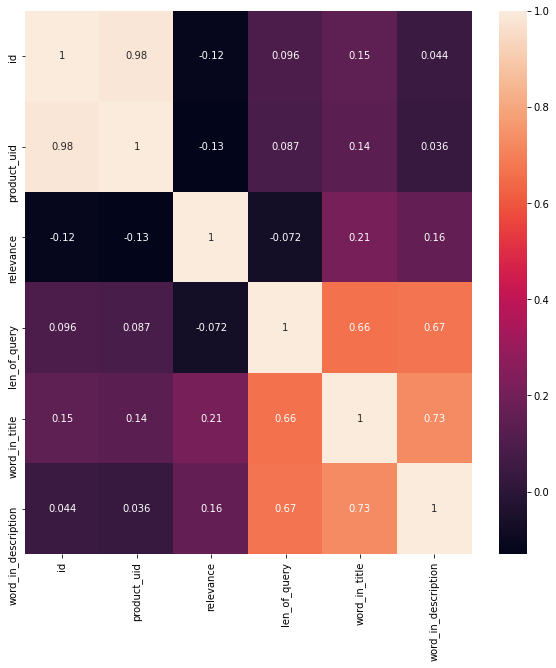

In [167]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True)

<Figure size 720x720 with 0 Axes>

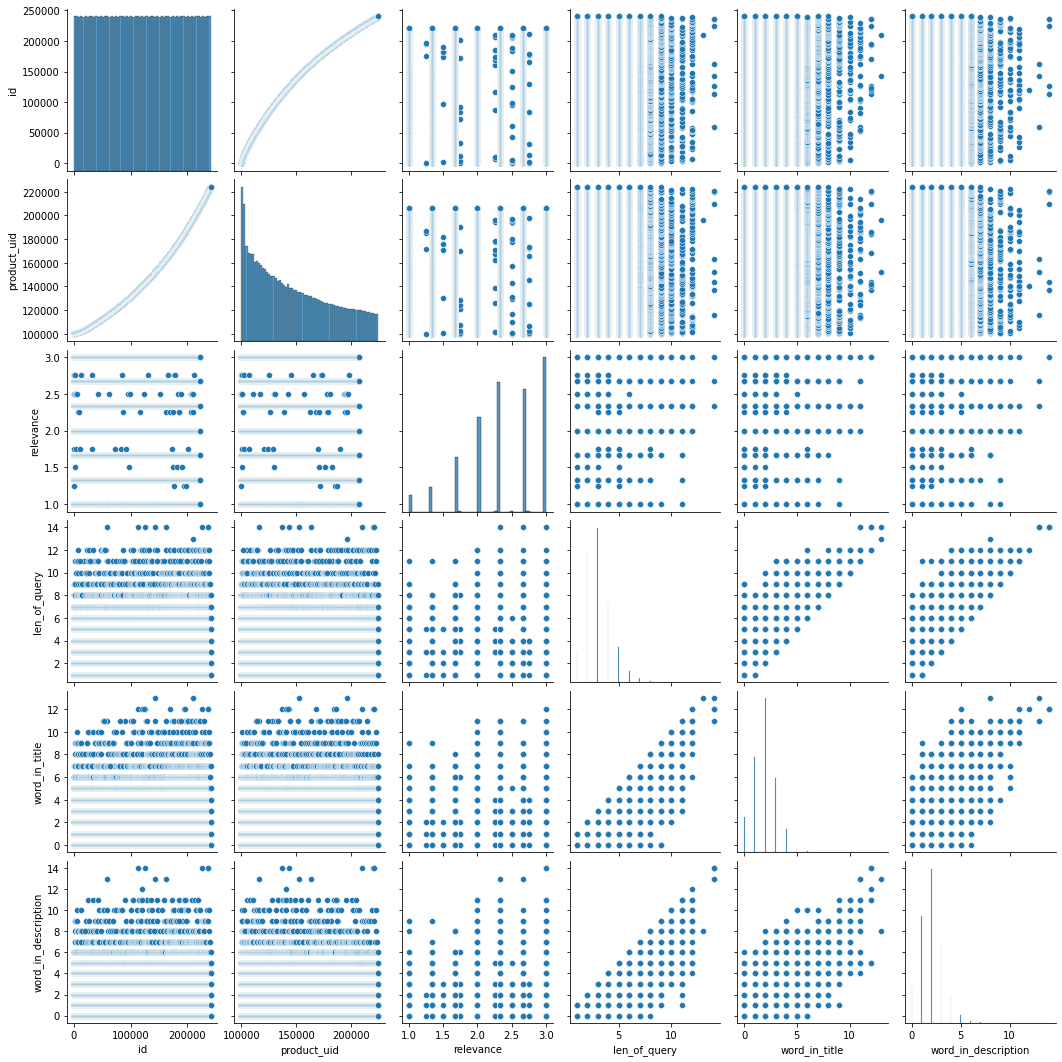

In [173]:
plt.figure(figsize=(10,10))
sns.pairplot(df)

**Determining MultiColinearity in the Dataset using Variance Inflation Factor**

In [169]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return(vif)
  

In [ ]:
df_train = df.iloc[:num_train]
df_test = df.iloc[num_train:]
id_test = df_test['id']

In [ ]:
print(df_train.shape, df_test.shape, id_test.shape)

(74067, 6) (166693, 6) (166693,)


In [ ]:
df_train.head()


,id,product_uid,relevance,len_of_query,word_in_title,word_in_description
0,2,100001,3.00,2,1,1
1,3,100001,2.50,2,1,1
2,9,100002,3.00,2,1,1
3,16,100005,2.33,3,1,1
4,17,100005,2.67,3,3,2


In [172]:
X=df
calc_vif(df_train)

,variables,VIF
0,id,24.237676
1,product_uid,84.743012
2,relevance,21.937658
3,len_of_query,16.486017
4,word_in_title,10.098137
5,word_in_description,9.658428


In [ ]:
df_test.head()

,id,product_uid,relevance,len_of_query,word_in_title,word_in_description
74067,1,100001,NaN,3,0,1
74068,4,100001,NaN,3,1,1
74069,5,100001,NaN,3,1,1
74070,6,100001,NaN,3,2,2
74071,7,100001,NaN,4,2,2


In [ ]:
id_test.head()

74067    1
74068    4
74069    5
74070    6
74071    7
Name: id, dtype: int64

**Train Test Split**


In [ ]:
y_train = df_train['relevance'].values
x_train = df_train.drop(['id','relevance'],axis=1).values
x_test = df_test.drop(['id','relevance'],axis=1).values

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape)

(74067, 4) (74067,) (166693, 4)


### **Training the Models**

### **Model - Random Forest Regressor**

**Hyperparameter Tuning** 

In [208]:
model1 = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators':[10, 15, 20, 25, 30, 40, 50], 'max_depth':[5,6,7,8,9,10]}, cv = 5)
model1.fit(x_train, y_train)  

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [207]:
y_pred = model1.predict(x_train)
print(model1.best_params_)

{'max_depth': 7, 'n_estimators': 30}


**Bulding the Model with Best Params**

In [199]:
model_rf = RandomForestRegressor(n_estimators=30, max_depth=7, random_state=0)
model_rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [201]:
y_pred_rf = model_rf.predict(x_train)
rmse_rf = mean_squared_error(y_train, y_pred_rf)
r2_rf = r2_score(y_train, y_pred_rf)
print("Mean Squared Error for the Training Set: ", rmse_rf)
print("R2 score for the Training Set: ", r2_rf)

Mean Squared Error for the Training Set:  0.22966794367422544
R2 score for the Training Set:  0.19452912587511018


In [202]:
y_pred_rf_test = model_rf.predict(x_test)
submissions_rf = pd.DataFrame({"id": id_test, "relevance": y_pred_rf_test})
submissions_rf.head()

,id,relevance
74067,1,2.059495
74068,4,2.225562
74069,5,2.225562
74070,6,2.350058
74071,7,2.194233


In [206]:
print(submissions_rf.shape)

(166693, 2)


In [209]:
submissions_rf.to_csv('submission_rf.csv', index=False)

In [211]:
files.download("submission_rf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Summary**

In the Public Kernels, Data Pre Processing was done by using Stemmer and scaled the Texts to Numerical Integer values which can be then interpreted. 

The numerical values represent the count of words in the search terms that are obtained from the Product Description, Attributes and the Product Title. Based on the count of words, a relationship to the Relevance score is acquired.

I have studied the features for Correlation and MultiColinearity to see if there is a linear relationship between the features.

Built a Random Forest Regressor and applied Hyperparameter tuning to optimize the model with the best hyperparameters.


## **Conclusion**

After Training and Optimizing Random Forest regressor and trying out other models as well, it is observed that the Random Forest Regressor has the best R2 Score which helps to predict the Search Term Relevance Accurately

### **References**

1. Kaggle Kernels 1 - https://www.kaggle.com/junfeng/sklearn-random-forest-merge-attributes/execution for Data Pre processing

2. Kaggle Kernels 2 - https://www.kaggle.com/anttip/first-xgb-script

3. Rest of the Code was written by me






### **LICENSE**

Copyright <2020> Keshav K L

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.